Running on cuda
Loading final agent from /content/drive/MyDrive/quant_projects/checkpoints/agent_iql_final.pth...
Running evaluation episodes...


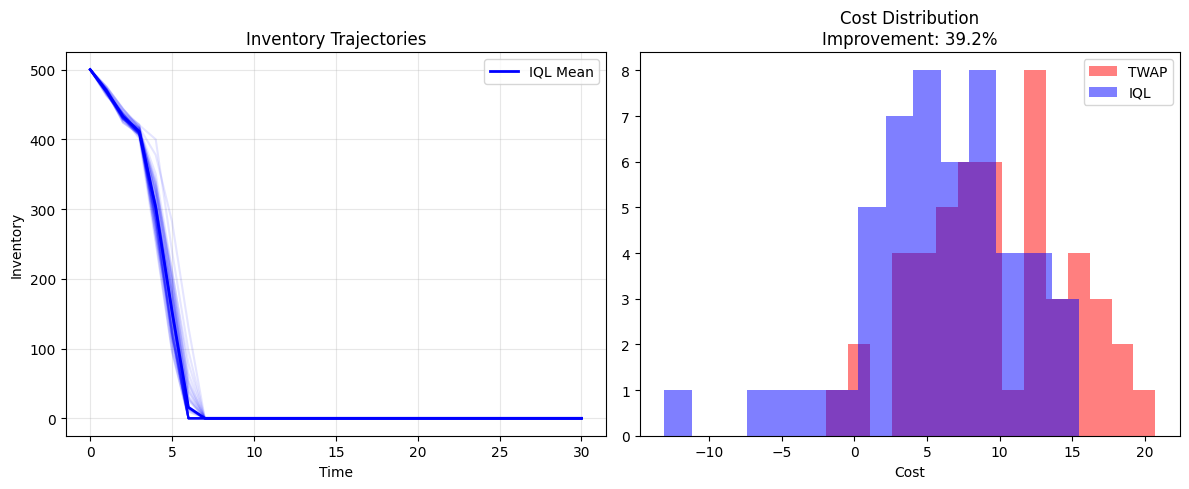

In [ ]:

import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict

try:
    import gymnasium
except ImportError:
    !pip install --quiet gymnasium[accept-rom-license] numpy tqdm matplotlib
    !pip install sympy==1.13.3 -q
    !pip install --quiet torch torchvision --extra-index-url https://download.pytorch.org/whl/cu118


from google.colab import drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')


ROOT_DIR = '/content/drive/MyDrive/quant_projects'
SRC_DIR = f'{ROOT_DIR}/src'
CHK_DIR = f'{ROOT_DIR}/checkpoints'
os.makedirs(SRC_DIR, exist_ok=True)
os.makedirs(CHK_DIR, exist_ok=True)
sys.path.append(SRC_DIR)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {device}")


from env_cmdp import ExecEnv

class CMDPEnv:
    def __init__(self, X=500.0, T=30, V=800.0, terminal_penalty=0.1, p_max=0.2, constraint_config=None):
        self.env = ExecEnv(X=X, T=T, V=V, terminal_penalty=terminal_penalty)
        self.p_max = p_max
        self.constraint_config = constraint_config or {}
        self.reset_metrics()

    def reset_metrics(self):
        self.ep_actions = []
        self.ep_exec = []
        self.ep_costs = []
        self.ep_x = []

    def reset(self, seed=None):
        self.reset_metrics()
        obs = self.env.reset(seed=seed)
        if isinstance(obs, tuple): obs = obs[0]
        return obs

    def step(self, action, lambda_vec=None):
        p = float(np.clip(np.asarray(action).item(), -self.p_max, self.p_max))
        res = self.env.step(np.array([p], dtype=np.float32))
        if len(res) == 4: obs, reward, done, info = res
        else: obs, reward, term, trunc, info = res; done = bool(term or trunc)

        self.ep_actions.append(p)
        self.ep_exec.append(float(info.get('exec_vol', 0.0)))
        self.ep_costs.append(float(info.get('instant_cost', 0.0)))
        self.ep_x.append(float(self.env.x))

        return obs, reward, done, info

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256, n_layers=2):
        super().__init__()
        layers = []
        in_dim = input_dim
        for _ in range(n_layers):
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.ReLU())
            in_dim = hidden_dim
        layers.append(nn.Linear(in_dim, output_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

class TwinQ(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super().__init__()
        self.q1 = MLP(state_dim + action_dim, 1, hidden_dim)
        self.q2 = MLP(state_dim + action_dim, 1, hidden_dim)
    def forward(self, state, action):
        sa = torch.cat([state, action], dim=1)
        return self.q1(sa), self.q2(sa)

class GaussianActor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action, hidden_dim=256):
        super().__init__()
        self.net = MLP(state_dim, hidden_dim * 2, hidden_dim)
        self.l1 = nn.Linear(state_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, action_dim)
        self.log_std = nn.Linear(hidden_dim, action_dim)
        self.max_action = max_action

    def forward(self, state):
        x = F.relu(self.l1(state))
        x = F.relu(self.l2(x))
        mean = self.mean(x)
        log_std = self.log_std(x).clamp(-20, 2)
        std = torch.exp(log_std)
        return mean, std

    def get_action(self, state, deterministic=False):
        mean, std = self(state)
        if deterministic:
            return torch.tanh(mean) * self.max_action
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()
        y_t = torch.tanh(x_t)
        return y_t * self.max_action

class IQLAgent:
    def __init__(self, state_dim, action_dim, act_limit, hidden_dim=256, lr=3e-4, device="cpu"):
        self.act_limit = act_limit
        self.device = device

        self.q_critic = TwinQ(state_dim, action_dim, hidden_dim).to(device)
        self.value_net = MLP(state_dim, 1, hidden_dim).to(device)
        self.actor = GaussianActor(state_dim, action_dim, act_limit, hidden_dim).to(device)

    def load(self, path):
        ckpt = torch.load(path, map_location=self.device)
        self.q_critic.load_state_dict(ckpt['q_critic'])
        self.value_net.load_state_dict(ckpt['value_net'])
        self.actor.load_state_dict(ckpt['actor'])

def pad_trajectories(trajs, max_len=31, pad_value=0.0):
    padded = []
    for t in trajs:
        if len(t) < max_len:
            t_padded = t + [pad_value] * (max_len - len(t))
            padded.append(t_padded)
        else:
            padded.append(t[:max_len])
    return np.array(padded)

def evaluate_and_plot(agent_path):
    print(f"Loading final agent from {agent_path}...")
    env = CMDPEnv(X=500.0, T=30, V=800.0, terminal_penalty=0.1)
    agent = IQLAgent(env.env.observation_space.shape[0], 1, env.p_max, device=device)

    if os.path.exists(agent_path):
        agent.load(agent_path)
    else:
        print("Checkpoint not found!")
        return

    rl_costs, twap_costs = [], []
    rl_inv_paths = []

    print("Running evaluation episodes...")
    for _ in range(50):
        # RL
        obs = env.reset(); done = False; cost=0; path=[env.env.x]
        while not done:
            with torch.no_grad():
                s = torch.as_tensor(obs.reshape(1,-1), dtype=torch.float32).to(device)
                a = agent.actor.get_action(s, deterministic=True) # Use correct method
                a = a.cpu().numpy().item()
            obs, _, done, info = env.step(a)
            cost += info.get('instant_cost',0)
            path.append(env.env.x)
        rl_costs.append(cost)
        rl_inv_paths.append(path)

        obs = env.reset(); done = False; cost=0
        while not done:
            rem_t = env.env.T - env.env.t
            a = (env.env.x / rem_t) if rem_t > 0 else env.env.x
            obs, _, done, info = env.step(a)
            cost += info.get('instant_cost',0)
        twap_costs.append(cost)

    rl_inv_arr = pad_trajectories(rl_inv_paths)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    for p in rl_inv_arr: plt.plot(p, color='b', alpha=0.1)
    plt.plot(np.mean(rl_inv_arr, axis=0), 'b', linewidth=2, label='IQL Mean')
    plt.title('Inventory Trajectories'); plt.xlabel('Time'); plt.ylabel('Inventory')
    plt.grid(True, alpha=0.3); plt.legend()

    plt.subplot(1,2,2)
    plt.hist(twap_costs, bins=15, color='r', alpha=0.5, label='TWAP')
    plt.hist(rl_costs, bins=15, color='b', alpha=0.5, label='IQL')
    imp = ((np.mean(twap_costs)-np.mean(rl_costs))/np.mean(twap_costs))*100
    plt.title(f'Cost Distribution\nImprovement: {imp:.1f}%')
    plt.xlabel('Cost'); plt.legend()

    plt.tight_layout()
    plt.show()

evaluate_and_plot(f"{CHK_DIR}/agent_iql_final.pth")